# AI LAB REPORT <br /> Application of ML to transcriptomics
<br />
Group: <br />Calda Lorenzo (3194670), Lolli Alberto Paolo (3224481), Masiello Mariano (3200991), Senel Ali Emre (3221337)

## INTRODUCTION:

#### **Background**<br />

Studying the relationship between cancer and the human genome is challenging due to the high variability in gene expression among individuals and even within a single person’s cancer cells. Cancer cells accumulate numerous mutations over time, making them complex to understand and treat. To effectively tackle cancer, it’s essential to study both DNA and RNA, as RNA provides the instructions that guide cell behavior, revealing how cancer cells interact with their environment, such as evading immune cells.<br />

Hypoxia, a condition where cancer cells are deprived of sufficient oxygen, is critical in understanding cancer. These rapidly growing cells require more oxygen than normal cells. In areas with large tumors, the blood supply often falls short, leading to hypoxic conditions. Under hypoxia, cancer cells may express abnormal genes to survive, becoming more aggressive and harder to treat. Identifying hypoxic cells and understanding their survival mechanisms can provide valuable insights for better treatments.<br />

The experiment involved growing cells under normal oxygen levels (21%) and reduced oxygen levels (1%). A single-cell RNA sequencing was then performed using Smart-Seq and Drop-Seq methods to analyze gene expression. <br /><br />

#### **Overall Aim**<br />
The data provided originates from two breast cancer cell lines: HCC1086 and MCF7. By comparing gene expression profiles of cells grown under hypoxic and normoxic conditions, we aim to uncover the molecular mechanisms and effects of hypoxia in these cancer cells. Using various techniques, we trained algorithms to distinguish between hypoxic and normoxic cells, aiming to identify more aggressive hypoxic cancer cells and potentially leading to better treatment strategies.<br /><br />


#### **Dataset**
The data were provided in .csv and .tsv format. Each column represents a single sequenced cell, identified by a unique name that includes information about whether the cell was grown in hypoxic or normoxic conditions, and for Smart-Seq, its position on the culture plate. Each row corresponds to a gene, identified by its official gene symbol. Entries in the table represent gene expression counts for Smart-Seq sequenced cells and Unique Molecular Identifier (UMI) counts for Drop-Seq sequenced cells. This structure allows for detailed analysis of gene expression in different environmental conditions.<br /><br />

#### **Methods**
Our work will be divided into 4 main sections:
1. Exploratory Data Analysis
2. Comparisons between datasets
2. Unsupervised Learning methods
3. Supervised Learning methods



In [2]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt             #visualisation
import seaborn as sns                       #visualisation
%matplotlib inline     
sns.set(color_codes=True)
import torch
from sklearn.model_selection import train_test_split
import pickle as pkl
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, classification_report, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

### Preprocessing Datasets

Before starting with the analyses we 

In [ ]:
def add_cell_prefix(df, prefix):
    df.index = [prefix + i for i in df.index]
    return df

#Remove extra quotes from the filenames
def extract_cell_name_smartseq(x):
    y = x.split("_")
    return y[len(y)-2]

def get_cell_name_smartseq(file_name):
    return extract_cell_name_smartseq(file_name)

def convert_indexes_to_cell_names_smartseq(df):
    df.index = [get_cell_name_smartseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_smartseq(df_meta, cell_name):
    return df_meta[df_meta["Cell name"]==cell_name]["Condition"].values[0]

def seperate_hypo_and_norm_smartseq(df, df_meta):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Hypo")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Norm" or get_cell_hypo_or_norm_smartseq(df_meta, x)=="Normo")]
    return df_hypo, df_norm

def process_df_smartseq(df, df_meta, prefix):
    df = convert_indexes_to_cell_names_smartseq(df)
    _, df_norm = seperate_hypo_and_norm_smartseq(df,df_meta)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

#Remove extra quotes from the filenames
def extract_cell_name_dropseq(x):
    y = x.split("_")
    return y[0]

def get_cell_name_dropseq(file_name):
    return extract_cell_name_dropseq(file_name)

def convert_indexes_to_cell_names_dropseq(df):
    df.index = [get_cell_name_dropseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_dropseq(cell_name):
    return cell_name.split("_")[-1]

def seperate_hypo_and_norm_dropseq(df):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Hypoxia")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Normoxia")]
    return df_hypo, df_norm

def process_df_dropseq(df, prefix):
    _, df_norm = seperate_hypo_and_norm_dropseq(df)
    df = convert_indexes_to_cell_names_dropseq(df)
    df_norm = convert_indexes_to_cell_names_dropseq(df_norm)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

In [ ]:
mcf7_smartS_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t", index_col=0)
mcf7_smartS_filn = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
hcc_smartS_meta = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_MetaData.tsv",delimiter="\t",index_col=0)
hcc_smartS_filn = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
mcf7_dropS_filn = pd.read_csv("Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
hcc_dropS_filn = pd.read_csv("Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T

In [ ]:
mcf7_smartS_filn, mcf7_smartS_filn_norm_idx = process_df_smartseq(mcf7_smartS_filn.copy(), mcf7_smartS_meta, "MCF7_")
hcc_smartS_filn, hcc_smartS_filn_norm_idx = process_df_smartseq(hcc_smartS_filn.copy(), hcc_smartS_meta, "HCC1806_")
mcf7_dropS_filn, mcf7_dropS_filn_norm_idx = process_df_dropseq(mcf7_dropS_filn, "MCF7_")
hcc_dropS_filn, hcc_dropS_filn_norm_idx = process_df_dropseq(hcc_dropS_filn, "HCC1806_")

In [ ]:
dataset_list = [mcf7_smartS_filn, hcc_smartS_filn, mcf7_dropS_filn, hcc_dropS_filn]
dataset_names = ["MCF7_SmartSeq", "HCC1806_SmartSeq", "MCF7_DropSeq", "HCC1806_DropSeq"]
datasets = dict(zip(dataset_names, dataset_list))
norm_idx_datasets = dict(zip(dataset_names, [mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx, mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx]))
del dataset_list, dataset_names

datasets_labeled_smartS_mcf = {}
for name, dataset in datasets.items():
    tmpDataset = dataset.copy()
    tmpDataset["mcf"] = np.ones_like(dataset.iloc[:, 0]) if "MCF7" in name else np.zeros_like(dataset.iloc[:, 0])
    tmpDataset["smart"] = np.ones_like(dataset.iloc[:, 0]) if "SmartSeq" in name else np.zeros_like(dataset.iloc[:, 0])
    datasets_labeled_smartS_mcf[name] = tmpDataset

In [ ]:
dropS_norm_idx = np.concatenate([mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx])
smartS_norm_idx = np.concatenate([mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx])

smartS_idx = np.concatenate([mcf7_smartS_filn.index, hcc_smartS_filn.index])

mcf7_idx = np.concatenate([mcf7_smartS_filn.index, mcf7_dropS_filn.index])

merged_norm_idx = np.concatenate([mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx, mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx])

In [ ]:
# for each dataset in datasets, create a target column which is one if the index is in idx_datasets[dataset] and 0 otherwise
for name, df in datasets.items():
    df["target"] = df.index.map(lambda x: 1 if x in norm_idx_datasets[name] else 0)

In [ ]:
for name in datasets:
    print(f'Length of {name} dataset: {datasets[name].shape}')


Length of MCF7_SmartSeq dataset: (250, 3001)
Length of HCC1806_SmartSeq dataset: (182, 3001)
Length of MCF7_DropSeq dataset: (21626, 3001)
Length of HCC1806_DropSeq dataset: (14682, 3001)


## Exploratory Data Analysis:

### SmartSeq MCF-7

We first focus our attention on the SmartSeq MCF-7 dataset

In [3]:
mcf7_unfil = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Unfiltered_Data.txt", delimiter=" ",index_col=0)
mcf7_fil = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Data.txt", delimiter=" ",index_col=0)
mcf7_fil_T = mcf7_fil.T
mcf7_unfil_T = mcf7_unfil.T

In [4]:
mcf7_unfil.head()

,output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam,output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam,output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam,output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam,output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam,output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam,output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam,output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam,output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam,output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam,...,output.STAR.4_H14_Hypo_S383_Aligned.sortedByCoord.out.bam,output.STAR.4_H1_Norm_S355_Aligned.sortedByCoord.out.bam,output.STAR.4_H2_Norm_S356_Aligned.sortedByCoord.out.bam,output.STAR.4_H3_Norm_S357_Aligned.sortedByCoord.out.bam,output.STAR.4_H4_Norm_S358_Aligned.sortedByCoord.out.bam,output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam,output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam,output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam,output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam,output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam
WASH7P,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
MIR6859-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WASH9P,1,0,0,0,0,1,10,1,0,0,...,1,1,0,0,0,0,1,1,4,5
OR4F29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
MTND1P23,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [5]:
df_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t",engine='python',index_col=0)
print("Dataframe dimensions:", np.shape(df_meta))
print("First column: ", df_meta.iloc[ : , 0])

Dataframe dimensions: (383, 8)
First column:  Filename
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam    MCF7
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam    MCF7
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam    MCF7
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam      MCF7
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam      MCF7
                                                            ... 
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam    MCF7
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam    MCF7
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam    MCF7
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam    MCF7
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam    MCF7
Name: Cell Line, Length: 383, dtype: object


In [6]:
df_meta

,Cell Line,Lane,Pos,Condition,Hours,Cell name,PreprocessingTag,ProcessingComments
Filename,,,,,,,,
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam,MCF7,output.STAR.1,A10,Hypo,72,S28,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam,MCF7,output.STAR.1,A11,Hypo,72,S29,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam,MCF7,output.STAR.1,A12,Hypo,72,S30,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam,MCF7,output.STAR.1,A1,Norm,72,S1,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam,MCF7,output.STAR.1,A2,Norm,72,S2,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
...,...,...,...,...,...,...,...,...
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam,MCF7,output.STAR.4,H5,Norm,72,S359,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam,MCF7,output.STAR.4,H6,Norm,72,S360,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam,MCF7,output.STAR.4,H7,Hypo,72,S379,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"


We first look to see if there are missing values

In [7]:
t = (mcf7_unfil.isnull().sum().to_frame(name='freq'))
t[t.freq > 0]

,freq


We now look at the cell case, trying to identify duplicate genes.

We construct a set containing tuples of genes expressed in identical amounts in each cell, this we hypothesize derives from the fact that some genes only activate simultaneously

In [ ]:
duplicates = list(mcf7_unfil[mcf7_unfil.duplicated(keep=False)].sum(axis=1).index)
cor_mat = mcf7_unfil_T[duplicates].corr()
set_of_dups = set()
seen = set()
for i in duplicates:
    pass
    if i not in seen:
        seen.add(i)
        dup_temp = tuple(cor_mat[i][cor_mat[i] == 1].index)
        for j in dup_temp:
            seen.add(j)
        set_of_dups.add(dup_temp) 

set_of_dups

{('"CCL3L3"', '"CCL3L1"'),
 ('"CD84"', '"WDR95P"'),
 ('"CLCN3P1"', '"OTOP3"'),
 ('"CSMD1"', '"SEZ6L"'),
 ('"FAR2P3"', '"KLF2P3"'),
 ('"GNLY"', '"KCNS2"', '"BCL6B"'),
 ('"HTR5A"', '"RNU6-539P"'),
 ('"IL12RB2"', '"GALNT17"', '"PON1"'),
 ('"LINC00477"', '"KNOP1P1"'),
 ('"LINC00856"', '"LINC00595"'),
 ('"LINC02183"', '"ADAMTS5"'),
 ('"MIR20A"', '"MIR19B1"'),
 ('"MIR3190"', '"MIR3191"'),
 ('"MIR548AA1"', '"MIR548D1"'),
 ('"MT1M"', '"ASPA"'),
 ('"MTCO2P11"', '"CACYBPP1"'),
 ('"PABPC1P2"', '"SLC22A14"'),
 ('"PANDAR"', '"LAP3P2"'),
 ('"RPL21P5"', '"RBFOX1"'),
 ('"RPL22P16"', '"RNA5SP450"'),
 ('"S1PR1"', '"MUC6"'),
 ('"SHISAL2A"', '"COQ10BP2"'),
 ('"SNORA36A"', '"MIR664B"'),
 ('"SNRPN"', '"SNURF"'),
 ('"SUGT1P4-STRA6LP"', '"STRA6LP"'),
 ('"UGT1A8"', '"UGT1A9"'),
 ('"VSTM4"', '"PSG1"')}

We look if some of these duplicates was removed

In [ ]:
found, not_found = 0, 0
for i in duplicates:
    try:
        mcf7_fil_T[i]
        print(f'{i} found')
        found += 1
    except:
        print(f'{i} not found')
        not_found += 1
print(f'found: {found}, not found: {not_found}')

"SHISAL2A" not found
"IL12RB2" not found
"S1PR1" not found
"CD84" not found
"GNLY" not found
"FAR2P3" not found
"KLF2P3" not found
"PABPC1P2" not found
"UGT1A8" found
"UGT1A9" found
"SLC22A14" not found
"COQ10BP2" not found
"PANDAR" found
"LAP3P2" found
"RPL22P16" not found
"GALNT17" not found
"PON1" not found
"HTR5A" not found
"SNORA36A" not found
"MIR664B" not found
"CSMD1" not found
"KCNS2" not found
"MIR548AA1" not found
"MIR548D1" not found
"MTCO2P11" not found
"CLCN3P1" not found
"SUGT1P4-STRA6LP" found
"STRA6LP" found
"MUC6" not found
"VSTM4" not found
"LINC00856" found
"LINC00595" found
"CACYBPP1" not found
"LINC00477" not found
"KNOP1P1" not found
"WDR95P" not found
"MIR20A" not found
"MIR19B1" not found
"RPL21P5" not found
"RNU6-539P" not found
"SNRPN" not found
"SNURF" not found
"RBFOX1" not found
"LINC02183" not found
"MT1M" not found
"ASPA" not found
"BCL6B" not found
"CCL3L3" found
"CCL3L1" found
"OTOP3" not found
"RNA5SP450" not found
"PSG1" not found
"MIR3190" not found

We now look to see if there are some duplicate cells

In [ ]:
mcf7_unfil_T[mcf7_unfil_T.duplicated(keep=False)] # No duplicated cells

,"""WASH7P""","""MIR6859-1""","""WASH9P""","""OR4F29""","""MTND1P23""","""MTND2P28""","""MTCO1P12""","""MTCO2P12""","""MTATP8P1""","""MTATP6P1""",...,"""MT-TH""","""MT-TS2""","""MT-TL2""","""MT-ND5""","""MT-ND6""","""MT-TE""","""MT-CYB""","""MT-TT""","""MT-TP""","""MAFIP"""


We now look at the correlations 

In [9]:
cell_corr = mcf7_unfil.corr()

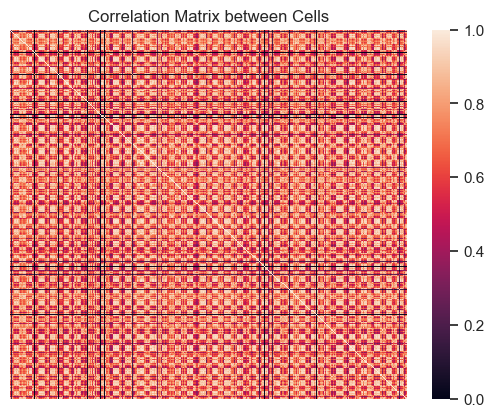

In [12]:
#represent cell_corr as a heat map
ax = plt.axes()
sns.heatmap(cell_corr, annot=False, xticklabels=False, yticklabels=False, ax=ax)
ax.set_title('Correlation Matrix between Cells')
plt.show()

In [13]:
cell_corr.describe()

,output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam,output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam,output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam,output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam,output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam,output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam,output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam,output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam,output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam,output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam,...,output.STAR.4_H14_Hypo_S383_Aligned.sortedByCoord.out.bam,output.STAR.4_H1_Norm_S355_Aligned.sortedByCoord.out.bam,output.STAR.4_H2_Norm_S356_Aligned.sortedByCoord.out.bam,output.STAR.4_H3_Norm_S357_Aligned.sortedByCoord.out.bam,output.STAR.4_H4_Norm_S358_Aligned.sortedByCoord.out.bam,output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam,output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam,output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam,output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam,output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,...,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,0.692450,0.182000,0.666715,0.678748,0.725266,0.721863,0.732166,0.729101,0.711603,0.787064,...,0.736796,0.685691,0.214466,0.705499,0.691587,0.723150,0.719689,0.472177,0.667416,0.735807
std,0.170704,0.066285,0.169978,0.129026,0.208038,0.220834,0.175528,0.221229,0.192707,0.158160,...,0.164004,0.216356,0.092332,0.233736,0.195422,0.210765,0.144407,0.154947,0.195828,0.176960
min,0.005703,-0.000855,0.000086,0.011887,0.004288,0.004259,0.008594,0.005119,0.004869,0.004868,...,0.005184,0.006376,0.001657,0.005096,0.006108,0.005317,0.004994,0.001056,0.003896,0.003699
25%,0.604644,0.147678,0.574979,0.663855,0.581749,0.557009,0.628897,0.568747,0.587429,0.759956,...,0.668222,0.520331,0.162807,0.524404,0.555735,0.583834,0.700745,0.365783,0.533252,0.642951
50%,0.702281,0.183206,0.641241,0.705830,0.764353,0.752969,0.777583,0.764261,0.775737,0.815693,...,0.728006,0.706024,0.200039,0.722554,0.736149,0.770749,0.749348,0.436102,0.662795,0.719326
75%,0.816015,0.214738,0.808728,0.742279,0.895716,0.921878,0.868596,0.932126,0.869369,0.867842,...,0.862874,0.882272,0.251492,0.927648,0.863396,0.903715,0.792625,0.588779,0.844365,0.889621
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We look at the cells which have the highest and lowest average correlation value

In [14]:
# return the columns with the lowest mean
cell_corr.describe().loc['mean'].sort_values(ascending=True)

output.STAR.1_H1_Norm_S337_Aligned.sortedByCoord.out.bam     0.007892
output.STAR.1_H5_Norm_S341_Aligned.sortedByCoord.out.bam     0.017576
output.STAR.1_B9_Hypo_S75_Aligned.sortedByCoord.out.bam      0.017935
output.STAR.3_E3_Norm_S207_Aligned.sortedByCoord.out.bam     0.018205
output.STAR.1_G12_Hypo_S318_Aligned.sortedByCoord.out.bam    0.037414
                                                               ...   
output.STAR.1_G7_Hypo_S313_Aligned.sortedByCoord.out.bam     0.778235
output.STAR.1_G9_Hypo_S315_Aligned.sortedByCoord.out.bam     0.780139
output.STAR.3_G7_Hypo_S325_Aligned.sortedByCoord.out.bam     0.783244
output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam      0.787064
output.STAR.4_C7_Hypo_S139_Aligned.sortedByCoord.out.bam     0.789184
Name: mean, Length: 383, dtype: float64

In [ ]:
# return the list of correlations by absolute value
def get_correlations(corr, threshold):
    cor_list = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold:
                cor_list.append([corr.columns[i], corr.columns[j], corr.iloc[i, j]])
    return cor_list

# sort 
sorted(get_correlations(cell_corr, 0.5), key=lambda x: x[2], reverse=True)

[['"output.STAR.4_F8_Hypo_S284_Aligned.sortedByCoord.out.bam"',
  '"output.STAR.4_F7_Hypo_S283_Aligned.sortedByCoord.out.bam"',
  0.9955045107896693],
 ['"output.STAR.4_D5_Norm_S167_Aligned.sortedByCoord.out.bam"',
  '"output.STAR.2_A3_Norm_S9_Aligned.sortedByCoord.out.bam"',
  0.9892120523390061],
 ['"output.STAR.3_A4_Norm_S16_Aligned.sortedByCoord.out.bam"',
  '"output.STAR.2_F1_Norm_S247_Aligned.sortedByCoord.out.bam"',
  0.9860843502864391],
 ['"output.STAR.3_H4_Norm_S352_Aligned.sortedByCoord.out.bam"',
  '"output.STAR.2_F1_Norm_S247_Aligned.sortedByCoord.out.bam"',
  0.9859694456677376],
 ['"output.STAR.4_F4_Norm_S262_Aligned.sortedByCoord.out.bam"',
  '"output.STAR.2_C4_Norm_S106_Aligned.sortedByCoord.out.bam"',
  0.985598045640576],
 ['"output.STAR.1_H3_Norm_S339_Aligned.sortedByCoord.out.bam"',
  '"output.STAR.1_E5_Norm_S197_Aligned.sortedByCoord.out.bam"',
  0.9850617557719057],
 ['"output.STAR.4_F5_Norm_S263_Aligned.sortedByCoord.out.bam"',
  '"output.STAR.4_D5_Norm_S167_Ali

## Comparison between Datasets:

## Unsupervised Learning:

## Supervised Learning: